In [2]:
#make necesarry imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from math import sqrt
import sys, os
from contextlib import contextmanager
import matplotlib as mpl
import seaborn as sns
import sklearn

In [3]:
df = pd.read_csv("forecasting_data.csv")
df.head()

,Period,Sales
0,1,5384
1,2,8081
2,3,10282
3,4,9156
4,5,6118


# 1. Visualize and interprete the pattern of this time-series

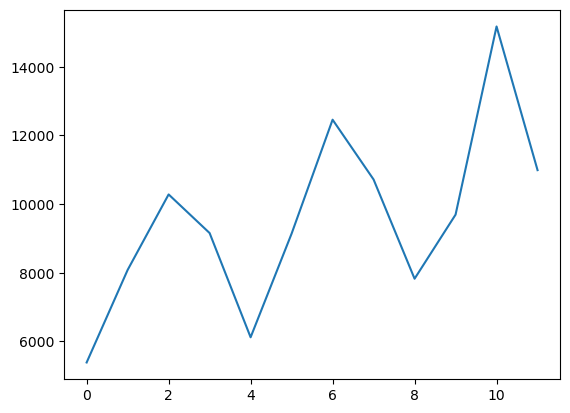

In [4]:
plt.plot(df["Sales"])
plt.show()

# 2. Predict future demand in month 13,14,15,16 without seasonality


# using moving average

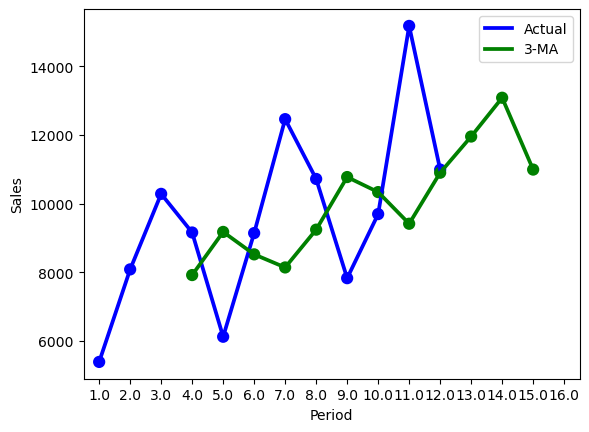

In [5]:
# Using moving average
def moving_average(df, k, to_period):
    moving_average_df = pd.DataFrame(columns=['Period','Sales'])
    for m in range(0, to_period):
        if m < k:
            prediction = float("nan")
        else:
            history = df["Sales"][m-k:m]
            prediction = history.mean()
        moving_average_df.loc[m] = [m+1, prediction]
    return moving_average_df

f, ax = plt.subplots(1, 1)
ma_df = moving_average(df, 3, 16)
sns.pointplot(x='Period', y='Sales', data=df, color='b')
sns.pointplot(x='Period', y='Sales', data=ma_df, color='g')
ax.legend(handles=ax.lines[::len(df)+1], labels=["Actual", "3-MA"])
plt.show()

# using exponential smothing


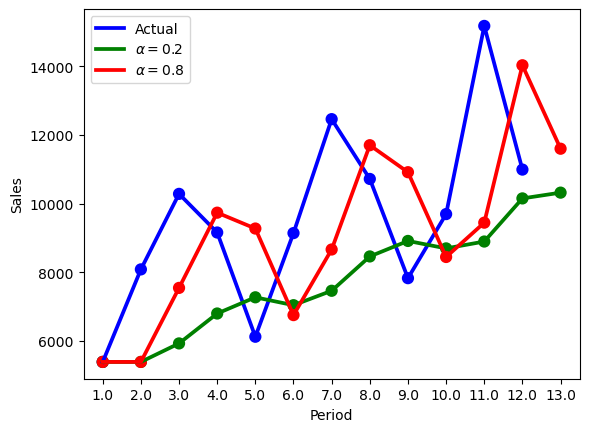

In [6]:
def exponential_smoothing(df, alpha):
    es_df = pd.DataFrame(columns=['Period','Sales'])
    es_df.loc[0] = [1, df["Sales"][0]]
    num_df = len(df)
    for m in range(0, num_df):
        prediction = alpha * df["Sales"][m] + (1 - alpha) * es_df["Sales"][m]
        es_df.loc[m+1] = [m+2, prediction]
    return es_df

f, ax = plt.subplots(1, 1)
es_df_02 = exponential_smoothing(df, 0.2)
es_df_08 = exponential_smoothing(df, 0.8)
sns.pointplot(ax=ax, x='Period', y='Sales', data=df, color='b')
sns.pointplot(ax=ax, x='Period', y='Sales', data=es_df_02, color='g')
sns.pointplot(ax=ax, x='Period', y='Sales', data=es_df_08, color='r')

ax.legend(handles=ax.lines[::len(df)+2], labels=["Actual", r'$\alpha=0.2$', r"$\alpha=0.8$"])
plt.show()



# 3. Predict future demand in the four next quarters with seasonality


Divide the time-series into 3 cycles (Month 1-4, 5-8, 9-12), then

v Compute the average sales for each cycle

v Compute the seasonal indices for each month of each cycle

v Compute the seasonal indices for next cycle

v Use linear regression on the average sales of cycles to predict the average sale for next cycle

v Compute the seasonalize forecasts 

         I     II    III
Seq                     
1     5384   6118   7825
2     8081   9139   9693
3    10282  12460  15177
4     9156  10717  10990
I       8225.75
II      9608.50
III    10921.25
dtype: float64
            I        II       III       Avg
Seq                                        
1    0.654530  0.636728  0.716493  0.669250
2    0.982403  0.951137  0.887536  0.940359
3    1.249977  1.296768  1.389676  1.312141
4    1.113090  1.115367  1.006295  1.078251
12038.807805355984


/var/folders/h0/8_wby_212cs0h3_gmjklt61c0000gn/T/ipykernel_55562/1805398430.py:47: RankWarning: Polyfit may be poorly conditioned
  season_df = predict_with_seasonality(df, [13,14,15,16])


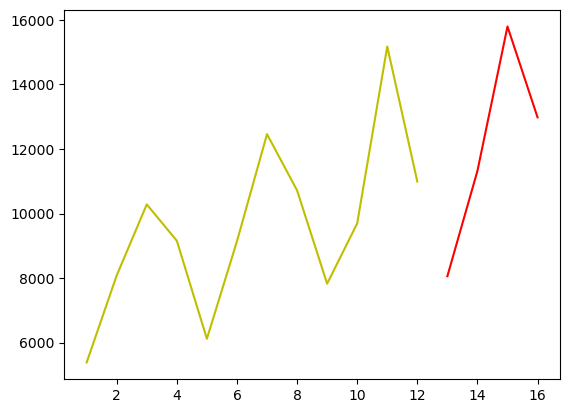

In [7]:
#season function
def get_season(row):
    if row['Period'] >= 5 and row['Period'] <= 8:
        return 'II'
    elif row['Period'] >= 9 and row['Period'] <= 12:
        return 'III'
    else:
        return 'I'
def get_seq(row):
    return row['Period']%4 and row['Period']%4 or 4

def predict_with_seasonality(df, months):
    new_df = df.copy()
    new_df['Season'] = new_df.apply(get_season, axis=1)
    new_df['Seq'] = new_df.apply(get_seq, axis=1)
    
    season_df = pd.DataFrame((new_df.pivot('Seq','Season')['Sales']).to_records())
    season_df.index = season_df['Seq']
    season_df = season_df.drop(['Seq'], axis=1)
    
    print(season_df)
    
    avg_df = season_df.apply(np.mean)
    
    print(avg_df)
    
    seasonal_index_df = pd.DataFrame(columns=['I','II','III'])
    seasonal_index_df['I'] = season_df["I"]/avg_df["I"]
    seasonal_index_df['II'] = season_df["II"]/avg_df["II"]
    seasonal_index_df['III'] = season_df["III"]/avg_df["III"]
    seasonal_index_df['Avg'] = seasonal_index_df.mean(axis=1)
    print(seasonal_index_df)
    
    season = np.array([1,2,3])
    avg_arr = np.array([avg_df['I'], avg_df['II'], avg_df['III']])
    fit = np.polyfit(season, avg_arr, 3)
    poly = np.poly1d(fit)
    average_predict = poly(4)
    print(average_predict)
    
    forecast_df = pd.DataFrame(columns=['Period','Sales'])
    forecast_df['Sales'] = seasonal_index_df["Avg"]*average_predict
    forecast_df['Period'] = months
    forecast_df.index = np.array(months) - 1
    return forecast_df

season_df = predict_with_seasonality(df, [13,14,15,16])

f, ax = plt.subplots(1, 1)
plt.plot(df['Period'], df['Sales'], c='y')
plt.plot(season_df['Period'], season_df['Sales'], c='r')
plt.show()



# 4.Evaluation: compare the above implemented methods

Compute forecast errors

Make conclusions

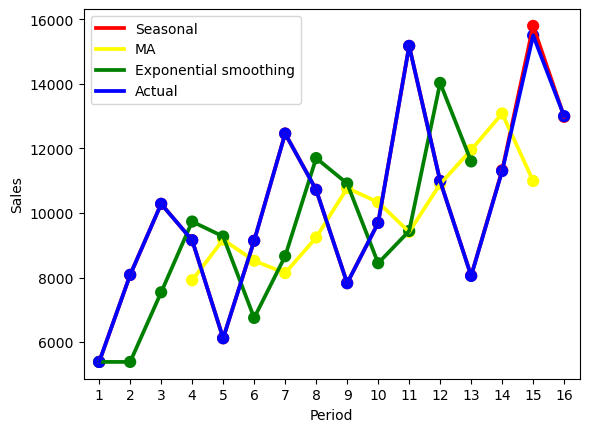

In [9]:
eval_df = pd.read_csv('forecasting_actual.csv')
eval_df = pd.concat([df, eval_df], ignore_index=True)

f, ax = plt.subplots(1, 1)
sns.pointplot(ax=ax, x='Period', y='Sales', data=pd.concat([df, season_df], ignore_index=True), color='r')
sns.pointplot(ax=ax, x='Period', y='Sales', data=ma_df, color='yellow')
sns.pointplot(ax=ax, x='Period', y='Sales', data=es_df_08, color='green')
sns.pointplot(ax=ax, x='Period', y='Sales', data=eval_df, color='b')
ax.legend(handles=ax.lines[::len(df)+5], labels=["Seasonal", 'MA', "Exponential smoothing", "Actual"])
plt.show()


In [10]:
MAD = np.absolute(eval_df["Sales"][12:16] - moving_average(eval_df, 3, 16)["Sales"][12:16]).mean()
print("MAD of {0}: {1}".format("3-MA", MAD))

MAD = np.absolute(eval_df["Sales"][12:16] - moving_average(eval_df, 3, 16)["Sales"][12:16]).mean()
print("MAD of {0}: {1}".format("Exponential smoothing with alpha=0.2", MAD))

MAD = np.absolute(eval_df["Sales"][12:16] - moving_average(eval_df, 3, 16)["Sales"][12:16]).mean()
print("MAD of {0}: {1}".format("Exponential smoothing with alpha=0.8", MAD))

MAD = np.absolute(eval_df["Sales"][12:16] - moving_average(eval_df, 3, 16)["Sales"][12:16]).mean()
print("MAD of {0}: {1}".format("Seasonality Method", MAD))

MAD of 3-MA: 2694.75
MAD of Exponential smoothing with alpha=0.2: 2694.75
MAD of Exponential smoothing with alpha=0.8: 2694.75
MAD of Seasonality Method: 2694.75


In [11]:
MSE = (eval_df["Sales"][12:16] - moving_average(eval_df, 3, 16)["Sales"][12:16])**2
MSE = MSE.mean()
print("MSE of {0}: {1}".format("3-MA", MSE))

MSE = (eval_df["Sales"][12:16] - moving_average(eval_df, 3, 16)["Sales"][12:16])**2
print("MSE of {0}: {1}".format("Exponential smoothing with alpha=0.2", MSE))

MSE = (eval_df["Sales"][12:16] - moving_average(eval_df, 3, 16)["Sales"][12:16])**2
print("MSE of {0}: {1}".format("Exponential smoothing with alpha=0.8", MSE))

MSE = (eval_df["Sales"][12:16] - moving_average(eval_df, 3, 16)["Sales"][12:16])**2
print("MSE of {0}: {1}".format("Seasonality Method", MSE))

MSE of 3-MA: 11544241.36111111
MSE of Exponential smoothing with alpha=0.2: 12    1.523601e+07
13    1.116544e+04
14    2.901618e+07
15    1.913611e+06
Name: Sales, dtype: float64
MSE of Exponential smoothing with alpha=0.8: 12    1.523601e+07
13    1.116544e+04
14    2.901618e+07
15    1.913611e+06
Name: Sales, dtype: float64
MSE of Seasonality Method: 12    1.523601e+07
13    1.116544e+04
14    2.901618e+07
15    1.913611e+06
Name: Sales, dtype: float64


# II. Time-Series Analyses for Electricity Consumption

1. Electricity Consumption Exploration

In [12]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing

In [13]:
# Load file
ec = pd.read_csv('opsd_germany_daily.csv', index_col=0)
ec.head()

,Consumption,Wind,Solar,Wind+Solar
Date,,,,
2006-01-01,1069.184,NaN,NaN,NaN
2006-01-02,1380.521,NaN,NaN,NaN
2006-01-03,1442.533,NaN,NaN,NaN
2006-01-04,1457.217,NaN,NaN,NaN
2006-01-05,1477.131,NaN,NaN,NaN


In [14]:
ec.describe()

,Consumption,Wind,Solar,Wind+Solar
count,4383.000000,2920.000000,2188.000000,2187.000000
mean,1338.675836,164.814173,89.258695,272.663481
std,165.775710,143.692732,58.550099,146.319884
min,842.395000,5.757000,1.968000,21.478000
25%,1217.859000,62.353250,35.179250,172.185500
50%,1367.123000,119.098000,86.407000,240.991000
75%,1457.761000,217.900250,135.071500,338.988000
max,1709.568000,826.278000,241.580000,851.556000


transform the dates into datetime format in pandas

In [15]:
ec.index = pd.to_datetime(ec.index)

type(ec.index)

pandas.core.indexes.datetimes.DatetimeIndex

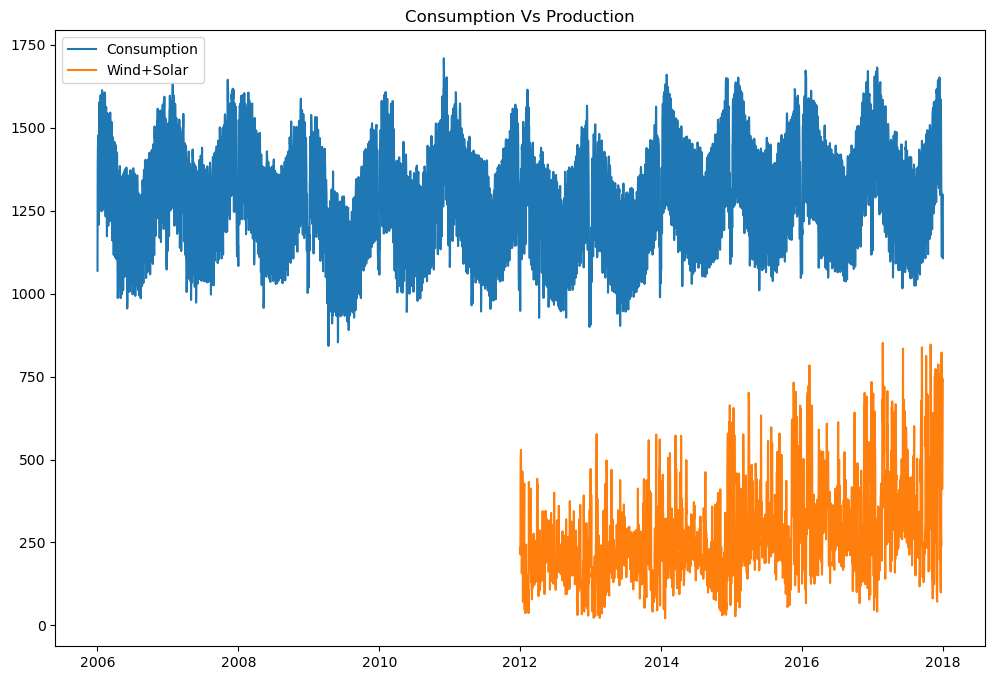

In [16]:
plt.figure(figsize=(12,8))
plt.plot(ec['Consumption'], label='Consumption')
plt.plot(ec['Wind+Solar'], label='Wind+Solar')
plt.title('Consumption Vs Production')

plt.legend()
plt.show()


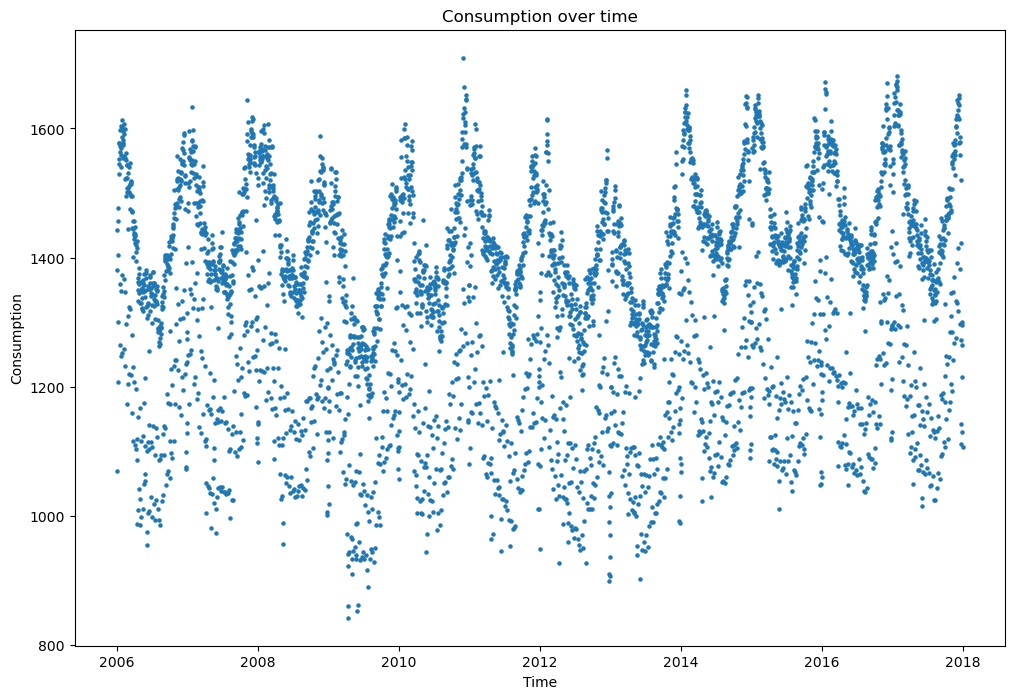

In [17]:
plt.figure(figsize=(12,8))

plt.scatter(ec.index, ec['Consumption'], s=5)

# add labels and title to the plot
plt.xlabel('Time')
plt.ylabel('Consumption')
plt.title('Consumption over time')

plt.show()

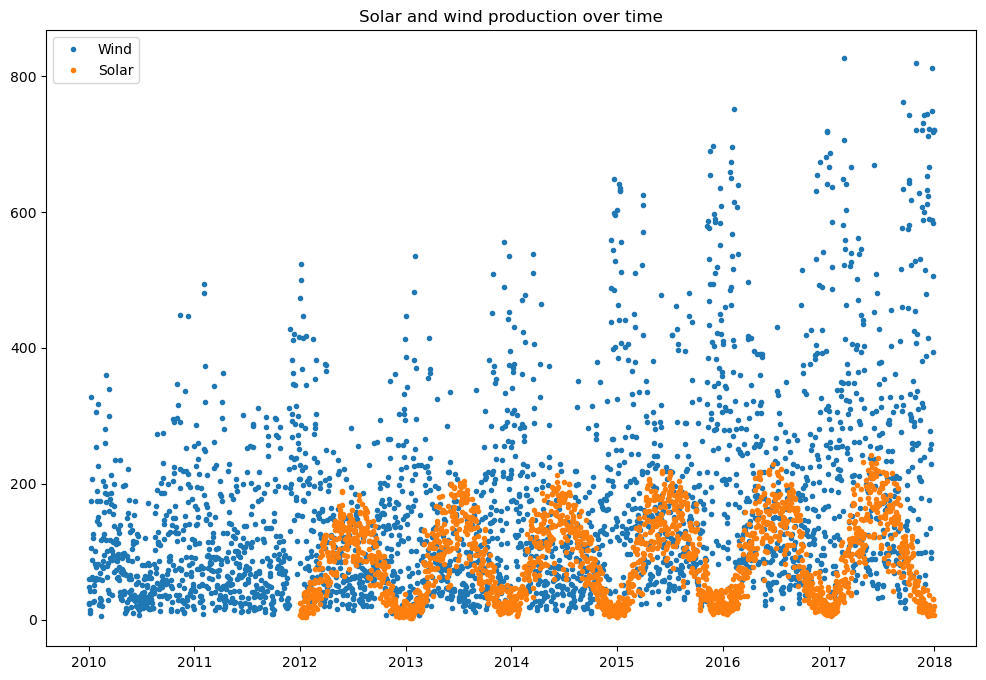

In [18]:
plt.figure(figsize=(12,8))
plt.plot(ec['Wind'], label='Wind', linestyle = "None", marker=".")
plt.plot(ec['Solar'], label='Solar', linestyle = "None", marker=".")
plt.title('Solar and wind production over time')

plt.legend()
plt.show()

What can we see?


* the consumption is larger than the production

* we have no overall production data before 2012

* the production and the consumption are both seasonal, i.e. they vary within a year given some pattern

* there is a trend in production (the higher part), and outliers downwards 



How do consumption and production compare?

* We notice that wind based production increases over time nad is rather high in winter(for example more storms).

* On the other hand, the solar production is higher in summer (seems logic)

* The consumption is higher in winter

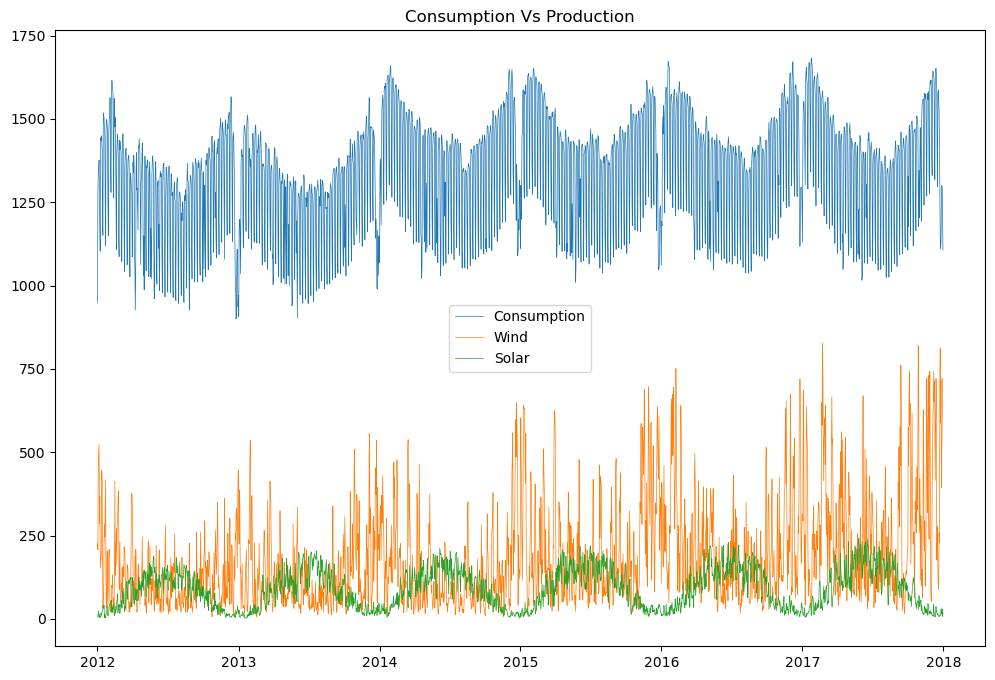

In [19]:
plt.figure(figsize=(12,8))

plt.plot(ec.loc["2012-01":"2017-12"]['Consumption'], label='Consumption', linewidth=0.5)
plt.plot(ec.loc["2012-01":"2017-12"]['Wind'], label='Wind', linewidth=0.5)
plt.plot(ec.loc["2012-01":"2017-12"]['Solar'], label='Solar', linewidth=0.5)

plt.title('Consumption Vs Production')
plt.legend()
plt.show()

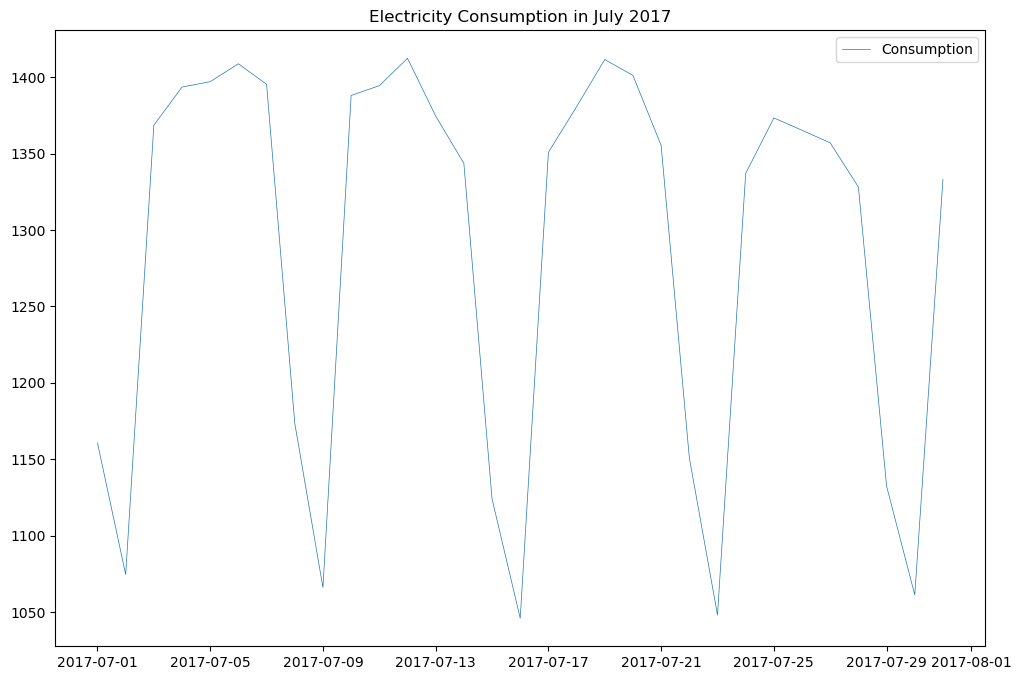

In [20]:
#plot over a month

plt.figure(figsize=(12,8))

plt.plot(ec.loc["2017-07-01":"2017-07-31"]['Consumption'], label='Consumption', linewidth=0.5)

plt.title('Electricity Consumption in July 2017')
plt.legend()
plt.show()


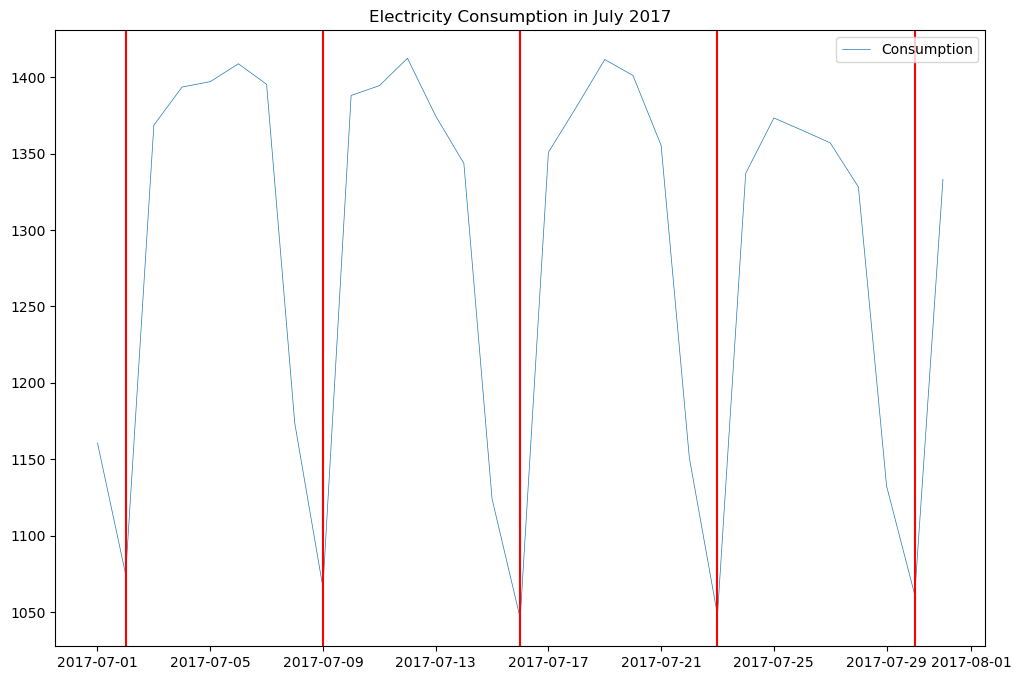

In [21]:
#plot on Sundays
plt.figure(figsize=(12,8))
plt.plot(ec.loc["2017-07-01":"2017-07-31"]['Consumption'], label='Consumption', linewidth=0.5)
plt.axvline(pd.to_datetime("2017-07-02"), c='r')
plt.axvline(pd.to_datetime("2017-07-09"), c='r')
plt.axvline(pd.to_datetime("2017-07-16"), c='r')
plt.axvline(pd.to_datetime("2017-07-23"), c='r')
plt.axvline(pd.to_datetime("2017-07-30"), c='r')
plt.title('Electricity Consumption in July 2017')
plt.legend()
plt.show()

# Further exploration

Q3 - To further explore the dataset, we might need to group the data. Create new columns for the consumption (by year and month), and create box-plots with seaborn. Comment on your results.

In [22]:
# new columns 'year' and 'month'
ec_2 = ec.reset_index()
ec_2['year'] = [d.year for d in ec_2.Date]
ec_2['month'] = [d.strftime("%b") for d in ec_2.Date]
years = ec_2['year'].unique()
print(years)
ec_2.head()

[2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017]


,Date,Consumption,Wind,Solar,Wind+Solar,year,month
0,2006-01-01,1069.184,NaN,NaN,NaN,2006,Jan
1,2006-01-02,1380.521,NaN,NaN,NaN,2006,Jan
2,2006-01-03,1442.533,NaN,NaN,NaN,2006,Jan
3,2006-01-04,1457.217,NaN,NaN,NaN,2006,Jan
4,2006-01-05,1477.131,NaN,NaN,NaN,2006,Jan


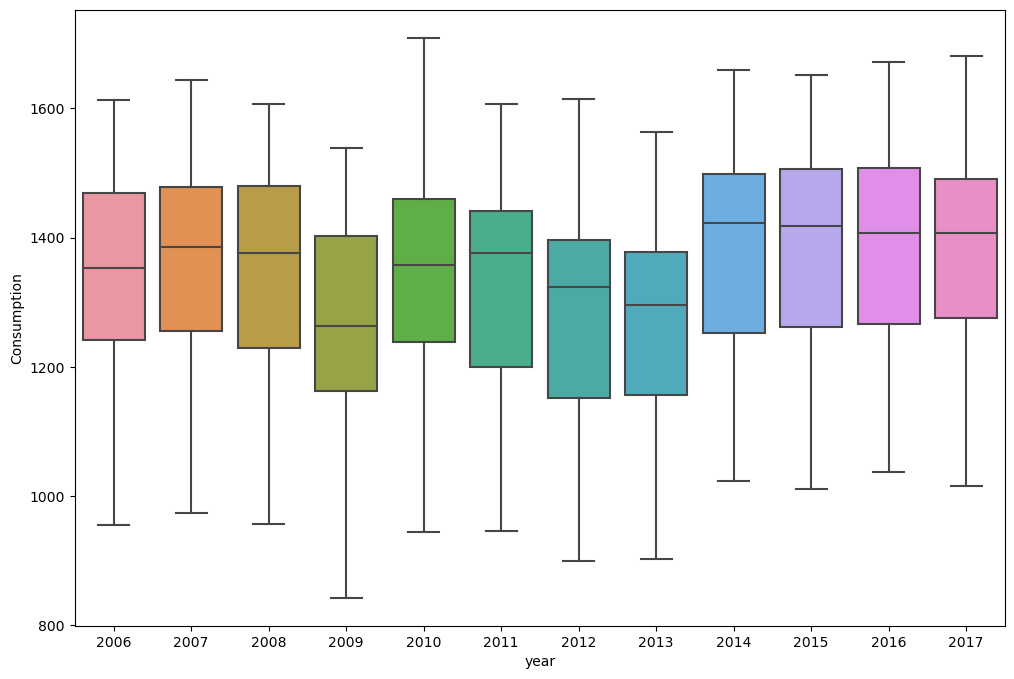

In [23]:
# Boxplot year
import seaborn as sns
plt.figure(figsize=(12,8))
sns.boxplot(x="year", y="Consumption", data=ec_2)
plt.show()

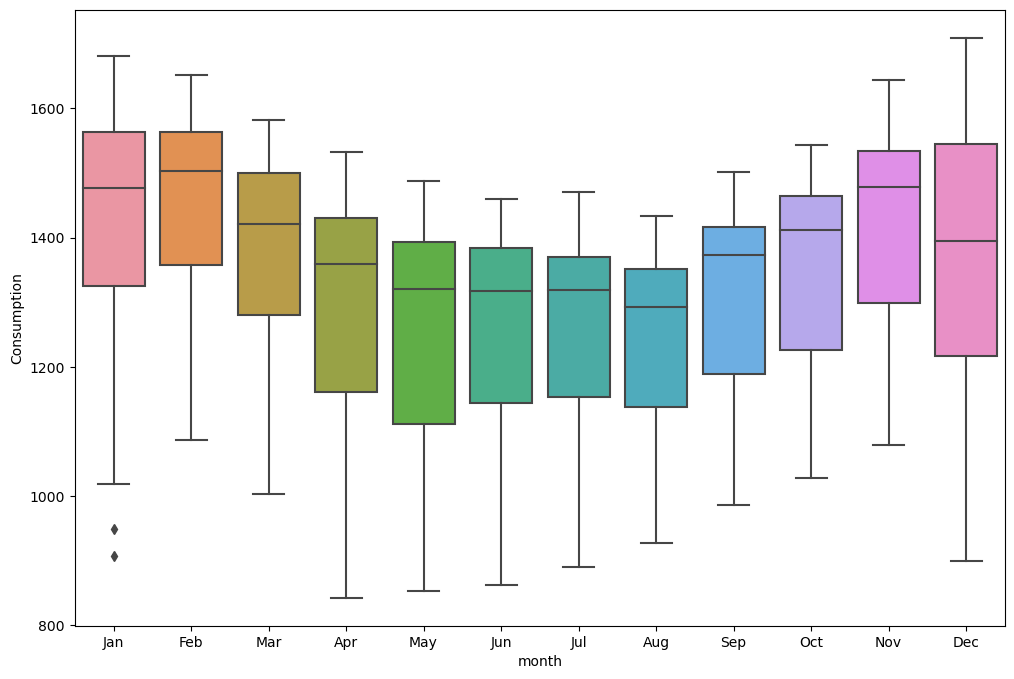

In [24]:
# Boxplot month
import seaborn as sns
plt.figure(figsize=(12,8))
sns.boxplot(x="month", y="Consumption", data=ec_2)
plt.show()

# 4. Fill missing values

Q4 - Do you face missing values in production ? If yes, which method can you apply ? What happens if you plot the modified data ? It is a good idea to keep the data this way ?

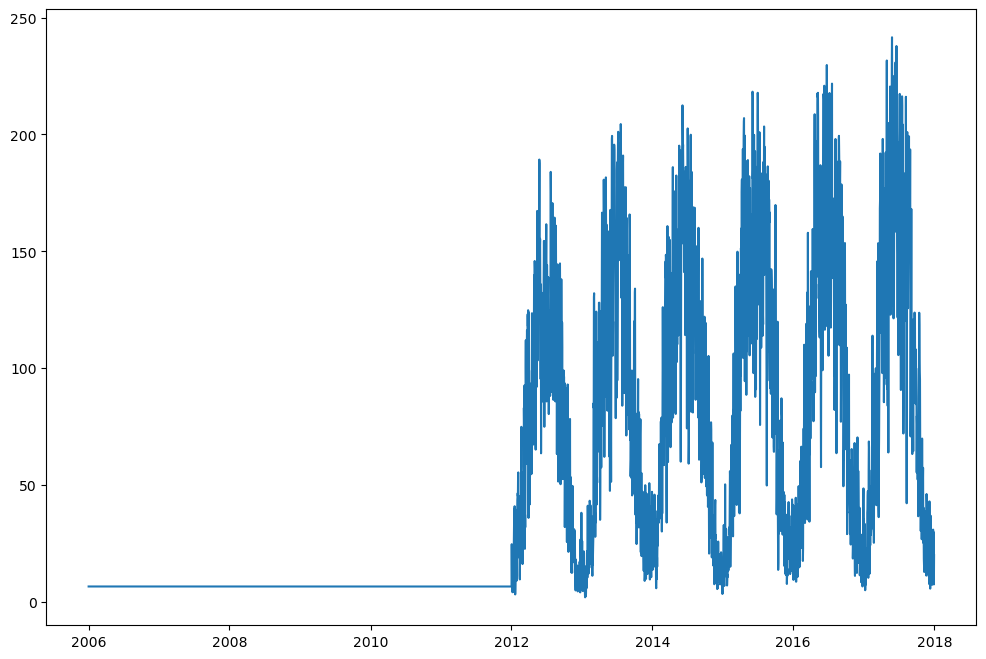

In [25]:
# Plot Solar
plt.figure(figsize=(12,8))
plt.plot(ec["Solar"].bfill(axis=0))
plt.show()

The forward and backward fill are useful when some values are missing within the data, not when we miss years of data. This is a clear illustration.

# 5. Series correlation¶

Q5 - A good way to explore time series, when you have several series, is to plot one series vs another. This is a good way to estimate the correlation between 2 series. Plot the relevant graphs (and compute the correlation) for wind + solar vs consumption, wind vs solar, wind vs consumption, and solar vs consumption.

In [26]:
# Correlation between consumption and overall production
ec["Consumption"]["2012-01-01":].corr(ec["Wind+Solar"]["2012-01-01":])

0.02764784385924093

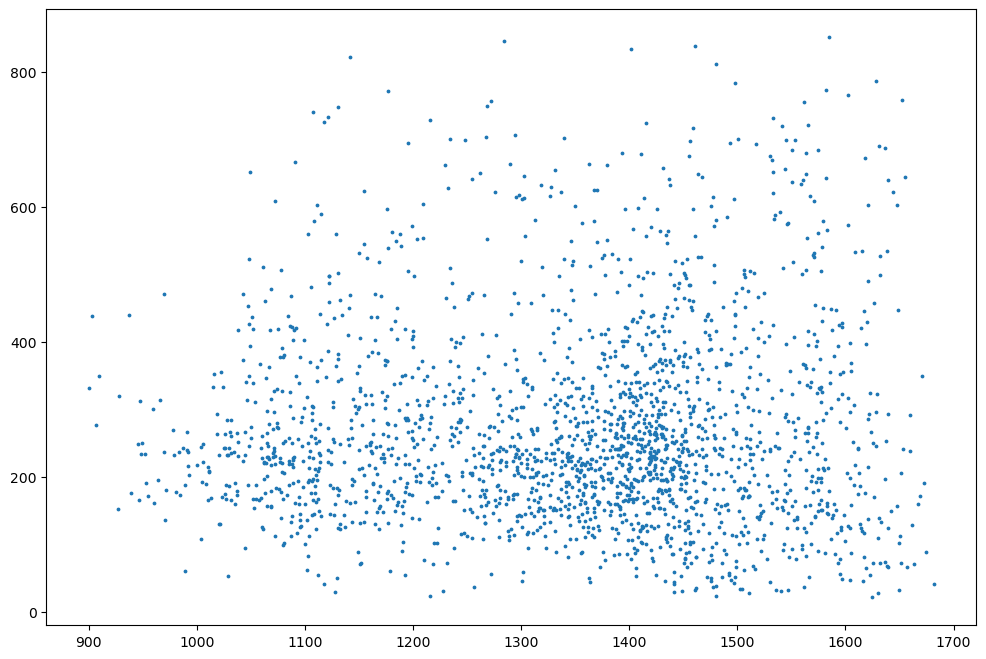

In [27]:
# Plot
plt.figure(figsize=(12,8))
plt.scatter(ec["Consumption"]["2012-01-01":], ec["Wind+Solar"]["2012-01-01":], s=3)
plt.show()

In [28]:
# Correlation between solar production and wind production
ec["Solar"]["2012-01-01":].corr(ec["Wind"]["2012-01-01":])

-0.3088318295977341

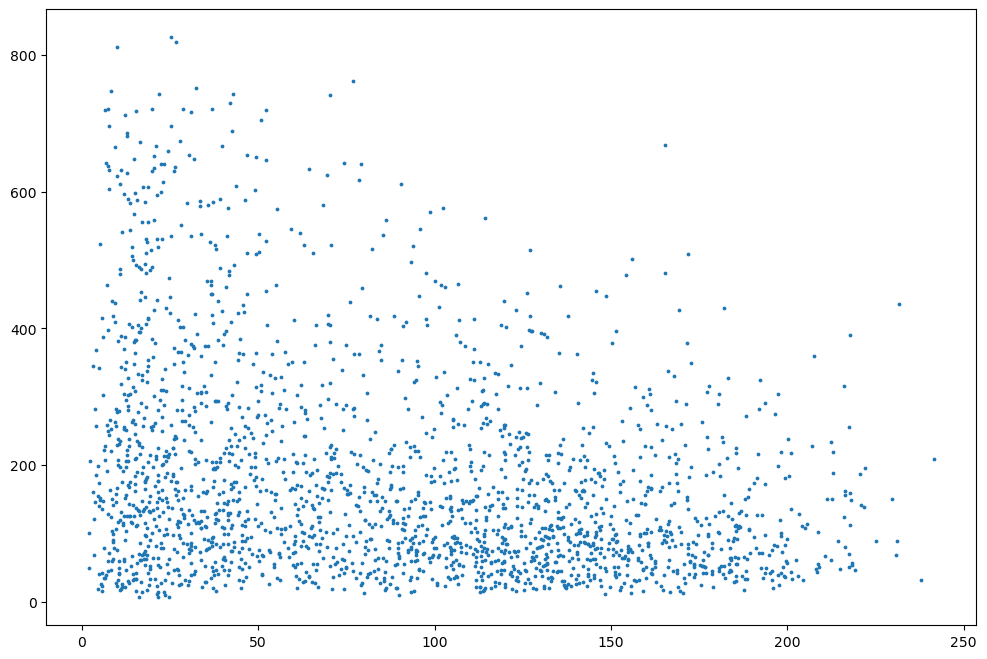

In [29]:
# Plot
plt.figure(figsize=(12,8))
plt.scatter(ec["Solar"]["2012-01-01":], ec["Wind"]["2012-01-01":], s=3)
plt.show()

The more solar there is, then there's less wind. A negative correlation between the two.

In [30]:
# Correlation between consumption and wind production
ec["Consumption"]["2012-01-01":].corr(ec["Wind"]["2012-01-01":])

0.13518640075918514

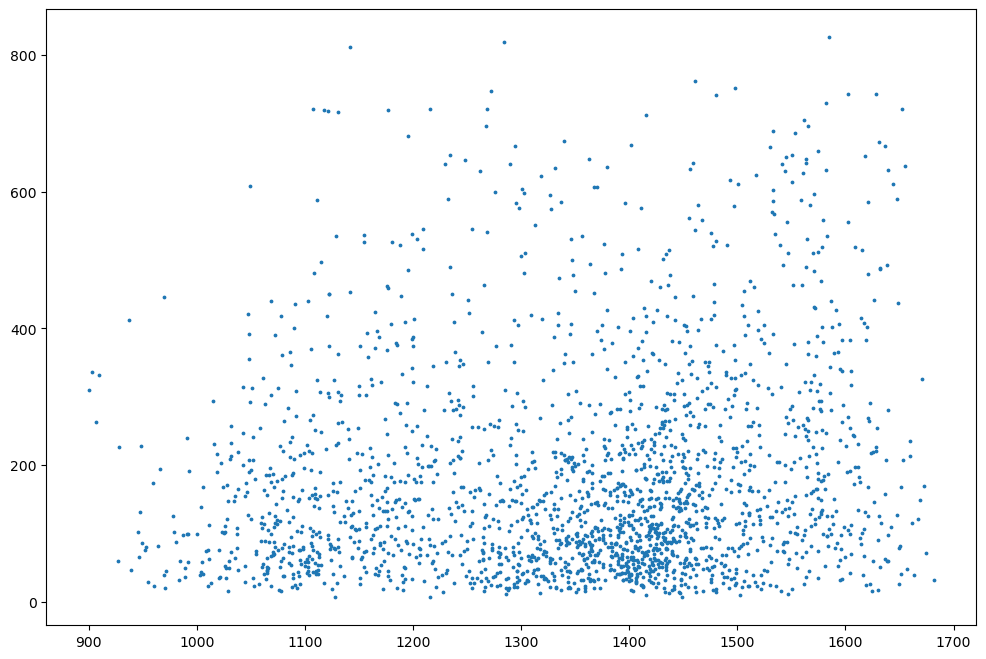

In [31]:
# Plot
plt.figure(figsize=(12,8))
plt.scatter(ec["Consumption"]["2012-01-01":], ec["Wind"]["2012-01-01":], s=3)
plt.show()

In [32]:
# Correlation between consumption and solar production
ec["Consumption"]["2012-01-01":].corr(ec["Solar"]["2012-01-01":])


-0.2789426551991438

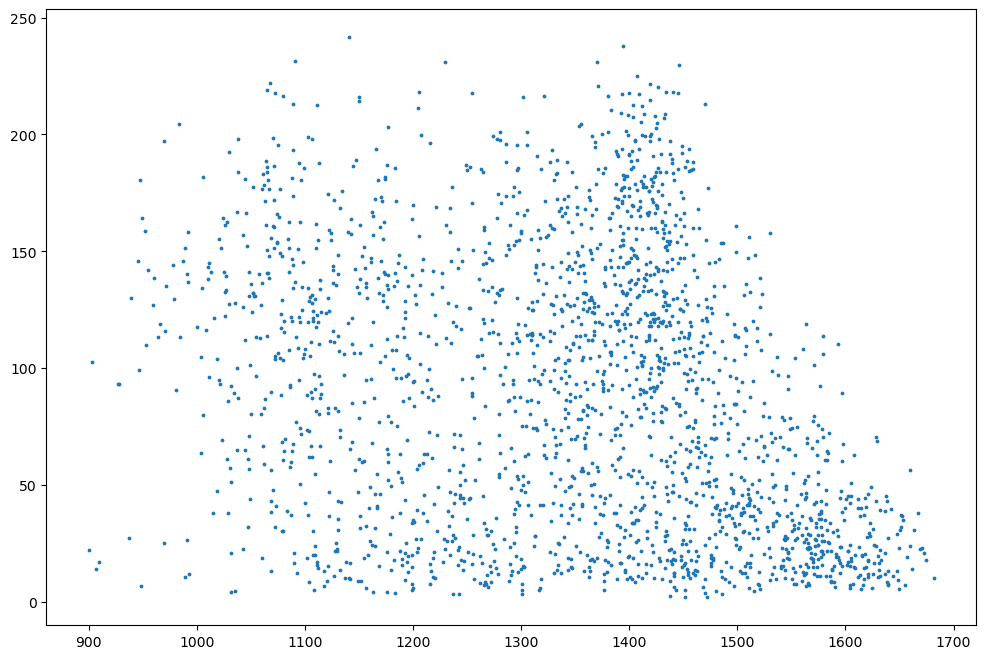

In [33]:
# Plot
plt.figure(figsize=(12,8))
plt.scatter(ec["Consumption"]["2012-01-01":], ec["Solar"]["2012-01-01":], s=3)
plt.show()

# Electricity-Consumption-Prediction

In [34]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing


I. Key concepts in time series

For what comes next, we will only focus on the consumption (and the prediction of the consumption).

Q1 - Plot the autocorrelation and partial autocorrelation of the consumption. What do you notice ?

/Users/alexia/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


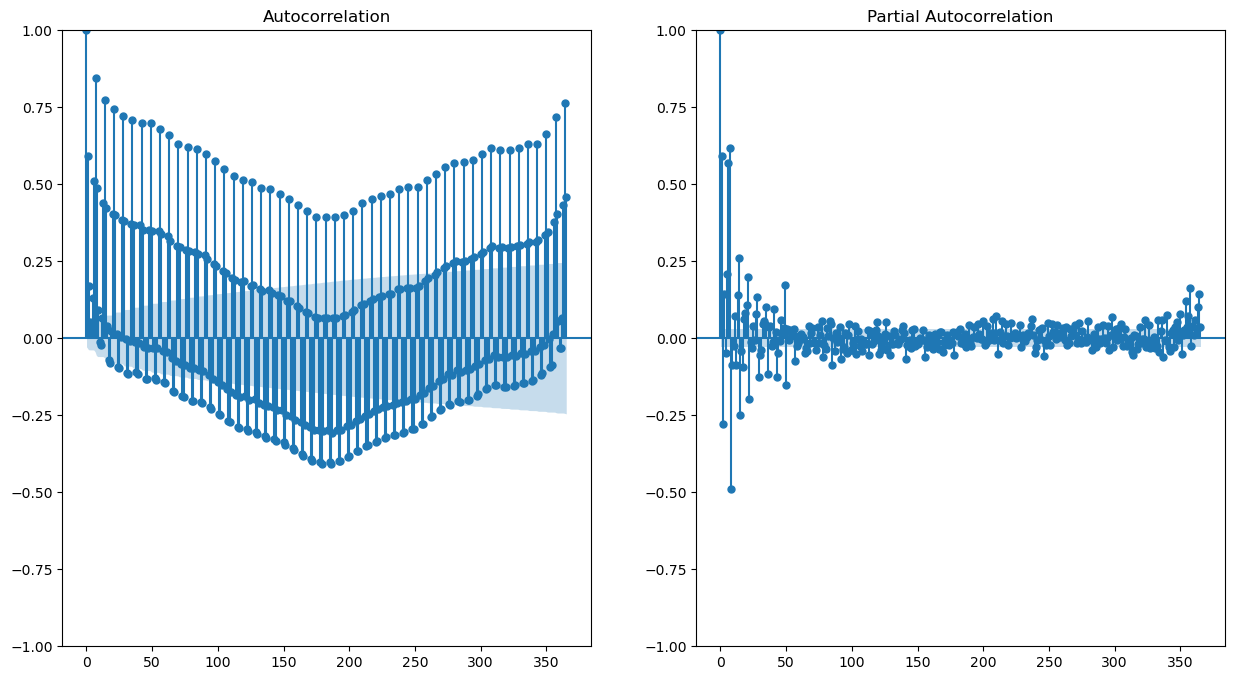

In [35]:
import statsmodels.api as sm

fig, axes = plt.subplots(1, 2, figsize=(15,8))

fig = sm.graphics.tsa.plot_acf(ec["Consumption"], lags=365, ax=axes[0])
fig = sm.graphics.tsa.plot_pacf(ec["Consumption"], lags=365, ax=axes[1])


There seems to ba a quite strong autocorrelation over time between the current values and the values 365 days ago, meaning that there is a cyclical effect in the consumption.

Q2 - Is the series stationary ?

In [36]:
# ADFuller 
from statsmodels.tsa.stattools import adfuller

result = adfuller(ec["Consumption"])
result

(-6.239148288864488,
 4.7440549018423125e-08,
 31,
 4351,
 {'1%': -3.4318538295011636,
  '5%': -2.8622045082106773,
  '10%': -2.5671237222704466},
 47966.592823559666)

The series is stationary according to the ADFuller test.

Q3 - Can you thing of any technique that could help our future model be more precise ?


We could try a de-trending (although there is no clear trend). We could also remove the seasonality in the time series.

# III. Decomposition and forecasting

1. Trends

Q4 - Try to apply de-trending. Is it interesting ?

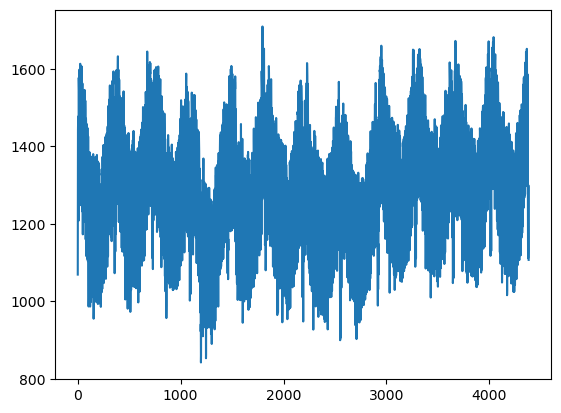

In [37]:
# LinearRegression                
from sklearn.linear_model import LinearRegression

X = np.array(range(len(ec['Consumption'])))
y = ec['Consumption']

reg = LinearRegression().fit(X.reshape(-1, 1), y)
pred_lin = reg.predict(X.reshape(-1,1))   

plt.plot(ec['Consumption'].values)

In [38]:
# polyfit & log trend + exp trend
a_1,b_1 = np.polyfit(np.log(X+1), y, 1)
a_2,b_2 = np.polyfit(X+1, np.log(y), 1)
pred_log = a_1 * np.log(X+1) + b_1
pred_exp = np.exp(b_2) + np.exp( (X+1) * a_2)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


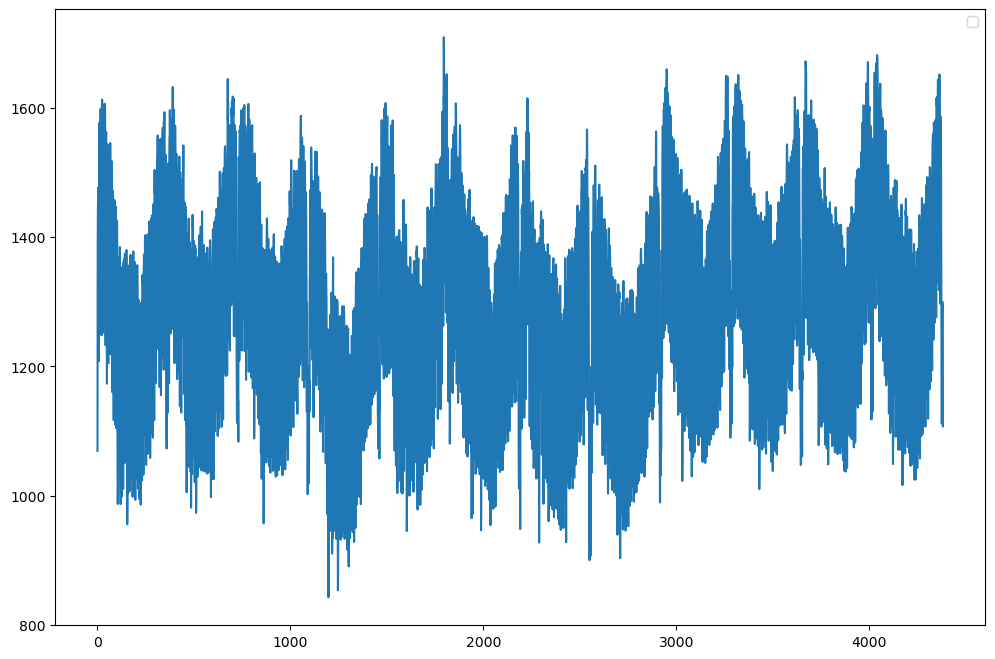

In [39]:
#how to plot it like in the examplar

plt.figure(figsize=(12,8))

plt.plot(ec['Consumption'].values)
plt.legend()

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# read the CSV file into a pandas DataFrame
df = pd.read_csv('filename.csv')

# create a scatter plot
plt.scatter(df['column_name_1'], df['column_name_2'], s=50)

# add labels and title to the plot
plt.xlabel('X-axis label')
plt.ylabel('Y-axis label')
plt.title('Scatter Plot title')

# calculate and plot the polynomial fit
p = np.polyfit(df['column_name_1'], df['column_name_2'], deg=3)
x = np.linspace(df['column_name_1'].min(), df['column_name_1'].max(), 100)
y = np.polyval(p, x)
plt.plot(x, y, label='Polyfit')

# calculate and plot the logarithmic trend
a, b = np.polyfit(np.log(df['column_name_1']), df['column_name_2'], 1)
x = np.linspace(df['column_name_1'].min(), df['column_name_1'].max(), 100)
y = a*np.log(x) + b
plt.plot(x, y, label='Logarithmic trend')

# calculate and plot the exponential trend
a, b = np.polyfit(df['column_name_1'], np.log(df['column_name_2']), 1)
x = np.linspace(ec['column_name_1'].min(), df['column_name_1'].max(), 100)
y = np.exp(a*x + b)
plt.plot(x, y, label='Exponential trend')

# add legend to the plot
plt.legend()

# display the plot
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: 'filename.csv'

In this case, there seems to be no clear trend pattern. We could consier skipping the de-trending.

We will apply a log transform for what comes next :

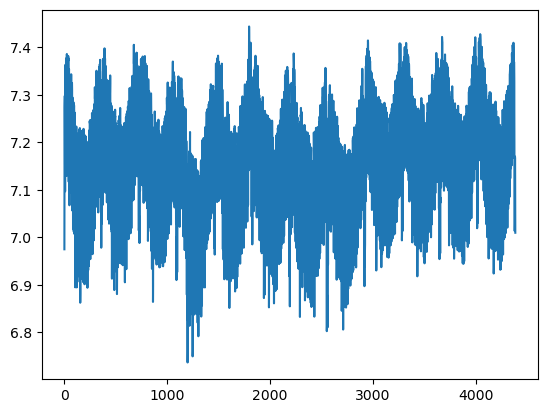

In [41]:
series = np.log(ec["Consumption"].values)
plt.plot(series)

# 2. Seasonality

Q5 - Try to remove the seasonality. Is it interesting ?

If we observe some seasonality over a year, the easiest option to remove the trend is to compute the first difference. For example, if there is a yearly seasonality, we can take  𝑦𝑡
  -  𝑦𝑡−365

In [42]:
from scipy.ndimage.interpolation import shift


/var/folders/h0/8_wby_212cs0h3_gmjklt61c0000gn/T/ipykernel_55562/1098188985.py:1: DeprecationWarning: Please use `shift` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  from scipy.ndimage.interpolation import shift


In [43]:
# series
series = shift(series, 365, cval=np.NaN)
series = series[np.isfinite(series)]

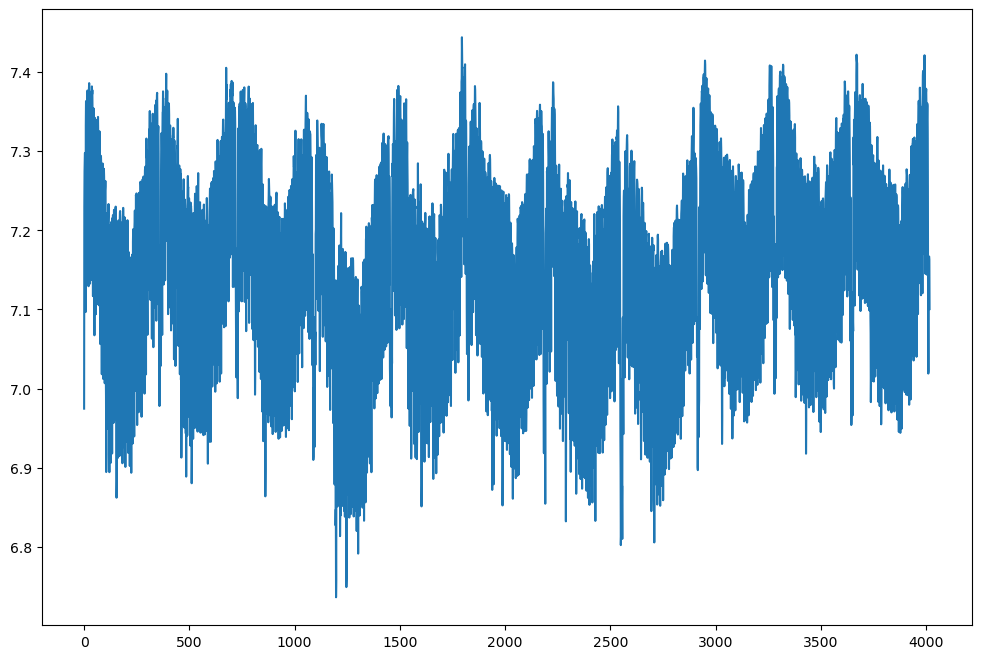

In [44]:
# plot
plt.figure(figsize=(12,8))
plt.plot(series, label="linear trend")
plt.show()

We have removed most of the trend here, and it seems like we remain with a stationary series.

Q6 - How does the ADFuller test compare now ? Did you improve anything ?

In [45]:
# ADFuller
from statsmodels.tsa.stattools import adfuller
result = adfuller(ec["Consumption"])
result

(-6.239148288864488,
 4.7440549018423125e-08,
 31,
 4351,
 {'1%': -3.4318538295011636,
  '5%': -2.8622045082106773,
  '10%': -2.5671237222704466},
 47966.592823559666)

before it was :
    (-6.239148288864488,
 4.7440549018423125e-08,
 31,
 4351,
 {'1%': -3.4318538295011636,
  '5%': -2.8622045082106773,
  '10%': -2.5671237222704466},
 47966.592823559666)
    
    
    Now it is:
        (-6.239148288864488,
 4.7440549018423125e-08,
 31,
 4351,
 {'1%': -3.4318538295011636,
  '5%': -2.8622045082106773,
  '10%': -2.5671237222704466},
 47966.592823559666)
        
        aka, no difference in values

Removing the trend did not improve anything. We will stay with the initial series.

# 3. Automatic Decomposition

Q7 - Does the automatic decomposition of statsmodels identify anything else ?

In [51]:
from statsmodels.tsa.seasonal import seasonal_decompose
# decomposition
decomposition = seasonal_decompose(series, period=365, extrapolate_trend="freq")

We set the period to 365 in this case since we observe a recurrent pattern over 365 days.

<Figure size 1200x800 with 0 Axes>

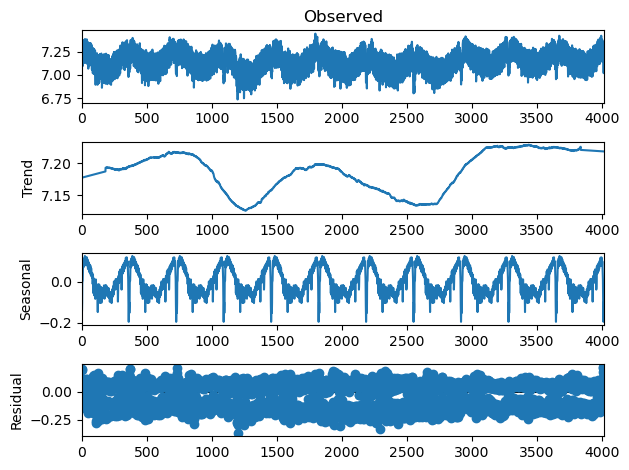

In [52]:
# plot
plt.figure(figsize=(12,8))
decomposition.plot()
plt.show()

# 4. Model the stationary series

Q8 - Taking years of training data is not always the best idea. Based on the decomposition above, what time frame seems the most relevant ?

In [53]:
series = series[-800:]


Moving Average (MA) processes

Q9 - Apply a Moving Average process on 20 % of test data. Comment your results.

In [54]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA

# train, test & history
size = int(len(series) * 0.8)
train, test = series[0:size], series[size:len(series)]
history = [x for x in train]
predictions = []

In [55]:
# walk forward over time steps in test
for t in range(len(test)):
    model = ARIMA(history, order=(0,0,1))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(yhat)

NotImplementedError: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been removed in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and statsmodels.tsa.SARIMAX.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained. It also offers alternative specialized
parameter estimators.


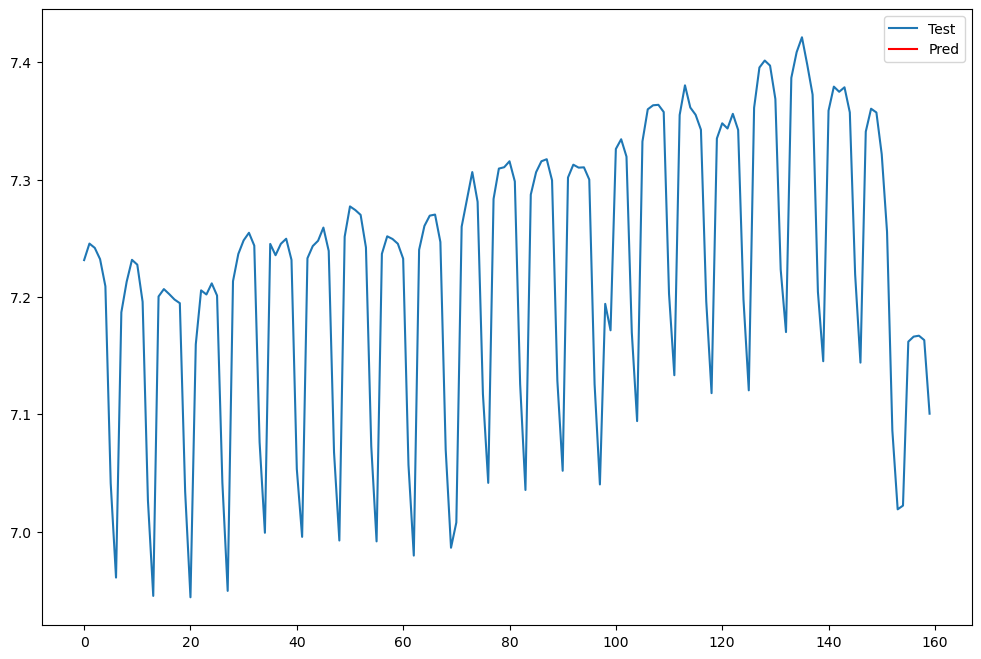

In [56]:
# Plot
plt.figure(figsize=(12,8))
plt.plot(test, label="Test")
plt.plot(np.array(predictions).reshape(1, -1)[0], color="red", label="Pred")
plt.legend()
plt.show()

Zoom on the prediction :


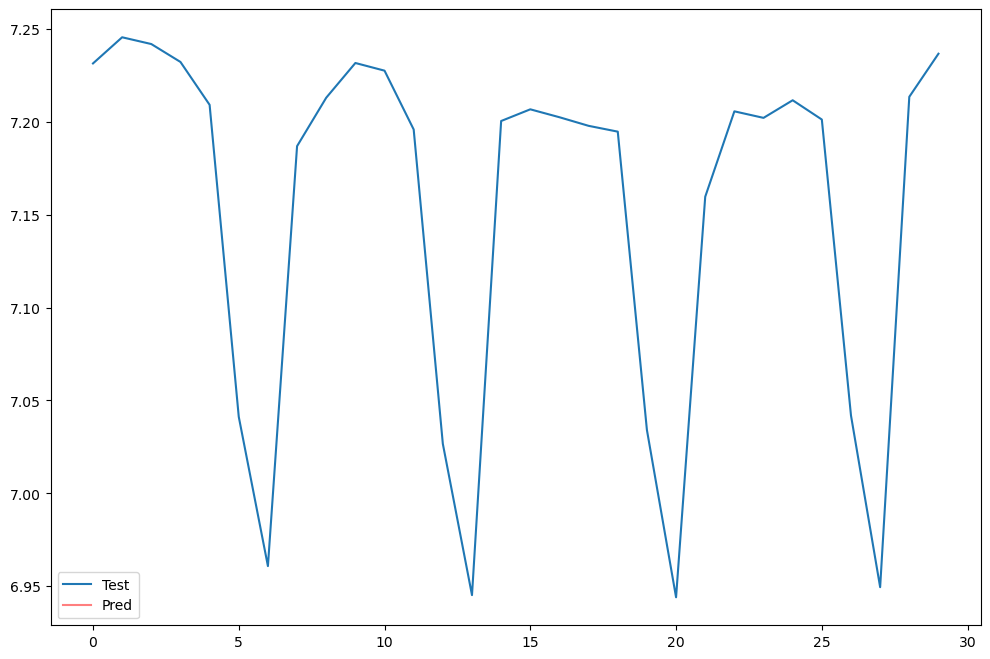

In [57]:
# Zoom
plt.figure(figsize=(12,8))
plt.plot(test[:30], label="Test")
plt.plot(np.array(predictions[:30]).reshape(1,-1)[0], color='red',alpha=0.5, label="Pred")
plt.legend()
plt.show()

In [58]:
# MSE
mean_squared_error(test, predictions)

ValueError: Found input variables with inconsistent numbers of samples: [160, 0]